# Qcodes example with Teledyne LeCroy 44MXs-B

In [32]:
import qcodes as qc
from qcodes.instrument_drivers.TeledyneLeCroy.TD44MXsB import TD44MXsB
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.data_set import load_by_id
from qcodes.dataset.data_export import get_data_by_id
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.database import initialise_database

In [27]:
import logging
import qcodes.logger as logger
from qcodes.logger import start_all_logging
start_all_logging()

Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\He5user\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import struct

In [3]:
osc = TD44MXsB('osc', 'TCPIP0::192.168.1.7::INSTR')

In [4]:
initialise_database()
qc.new_experiment(name='TD44MXsB_test', sample_name='no_sample')

TD44MXsB_test#no_sample#10@C:\Users\He5user/experiments.db
----------------------------------------------------------

In [ ]:
osc.C3.waveform.prepare_waveform()

meas = Measurement()
meas.register_parameter(osc.C3.waveform, paramtype='array')

with meas.run() as datasaver:
    waveform = osc.C3.waveform.get()
    datasaver.add_result((osc.C3.waveform, waveform))
    run_id = datasaver.run_id

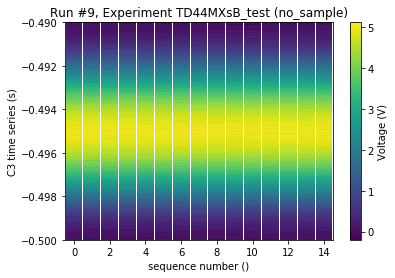

In [77]:
ds = load_by_id(run_id)

title = f"Run #{run_id}, Experiment {ds.exp_name} ({ds.sample_name})"
param_labels = [f'{param.label} ({param.unit})' for param in ds.get_parameters()]
param_names = [param.name for param in ds.get_parameters()]
X, Y, Z = ds.get_data(*param_names)[0]

fig, ax = plt.subplots()
mesh = ax.pcolormesh(X-0.5, Y-0.5, Z, rasterized=True)
#ax.axis([X.min(), X.max(), Y.min(), Y.max()])
cax = plt.colorbar(mesh, ax=ax);

ax.set_title(title)
ax.set_xlabel(param_labels[0])
ax.set_ylabel(param_labels[1])
cax.set_label(param_labels[2])

In [64]:
print(osc.visa_handle.query("C3:INSPECT? WAVEDESC"))

"
DESCRIPTOR_NAME    : WAVEDESC           
TEMPLATE_NAME      : LECROY_2_3         
COMM_TYPE          : byte               
COMM_ORDER         : LOFIRST            
WAVE_DESCRIPTOR    : 346                
USER_TEXT          : 0                  
RES_DESC1          : 0                  
TRIGTIME_ARRAY     : 256                
RIS_TIME_ARRAY     : 0                  
RES_ARRAY1         : 0                  
WAVE_ARRAY_1       : 16000032           
WAVE_ARRAY_2       : 0                  
RES_ARRAY2         : 0                  
RES_ARRAY3         : 0                  
INSTRUMENT_NAME    : LECROYWS44MXs-B    
INSTRUMENT_NUMBER  : 69503              
TRACE_LABEL        :                    
RESERVED1          : 9248               
RESERVED2          : 244                
WAVE_ARRAY_COUNT   : 16000032           
PNTS_PER_SCREEN    : 16000000           
FIRST_VALID_PNT    : 0                  
LAST_VALID_PNT     : 16000031           
FIRST_POINT        : 0                  
SPARSING_FACTO

In [65]:
print(osc.visa_handle.query("TMPL?"))

"
/00
000000              LECROY_2_3:  TEMPLATE
                    8 66 111
;
; Explanation of the formats of waveforms and their descriptors on the
; LeCroy Digital Oscilloscopes,
;     Software Release 8.1.0, 98/09/29.
;
; A descriptor and/or a waveform consists of one or several logical data blocks
; whose formats are explained below.
; Usually, complete waveforms are read: at the minimum they consist of
;       the basic descriptor block WAVEDESC
;       a data array block.
; Some more complex waveforms, e.g. Extrema data or the results of a Fourier
; transform, may contain several data array blocks.
; When there are more blocks, they are in the following sequence:
;       the basic descriptor block WAVEDESC
;       the history text descriptor block USERTEXT (may or may not be present)
;       the time array block (for RIS and sequence acquisitions only)
;       data array block
;       auxiliary or second data array block
;
; In the following explanation, every element of a block

In [66]:
%%timeit
osc.visa_handle.write("C3:WF?")
full = osc._read_ieee_block()

comm_type, comm_order = struct.unpack_from('??', full, 32)
dat1_offset = np.sum(struct.unpack_from('6l', full, 36))
dat1_length, = struct.unpack_from('l', full, 60)
Nsamples, = struct.unpack_from('L', full, 116)
Nseq, = struct.unpack_from('L', full, 144)
vert_gain, vert_offset = struct.unpack_from('ff', desc, 156)
horz_dt, horz_offset = struct.unpack_from('fd', desc, 176)
dat1_array = np.ndarray((Nseq,int(Nsamples/Nseq)),'h' if comm_type else 'b', full, dat1_offset)

times = horz_offset + horz_dt * np.arange(int(Nsamples/Nseq))
waves = vert_offset + vert_gain * dat1_array

3.47 s ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
osc.visa_handle.write("C3:WF?")
full = osc._read_ieee_block()

comm_type, comm_order = struct.unpack_from('??', full, 32)
dat1_offset = np.sum(struct.unpack_from('6l', full, 36))
dat1_length, = struct.unpack_from('l', full, 60)
Nsamples, = struct.unpack_from('l', full, 116)
Nseq, = struct.unpack_from('l', full, 144)
vert_gain, vert_offset = struct.unpack_from('ff', full, 156)
horz_dt, horz_offset = struct.unpack_from('fd', full, 176)
dat1_array = np.ndarray((Nseq,int(Nsamples/Nseq)),'h' if comm_type else 'b', full, dat1_offset)

times = horz_offset + horz_dt * np.arange(int(Nsamples/Nseq))
waves = vert_offset + vert_gain * dat1_array

In [68]:
waves

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.06641869],
       [ 0.        ,  0.        , -0.06641869, ...,  0.06641869,
         0.        ,  0.        ],
       [ 0.        ,  0.06641869,  0.        , ...,  0.13283737,
         0.        ,  0.06641869],
       ...,
       [ 0.06641869, -0.06641869,  0.        , ...,  0.        ,
         0.06641869,  0.        ],
       [ 0.        , -0.13283737,  0.13283737, ...,  0.06641869,
        -0.06641869, -0.06641869],
       [ 0.06641869,  0.06641869,  0.        , ...,  0.        ,
         0.06641869, -0.06641869]])

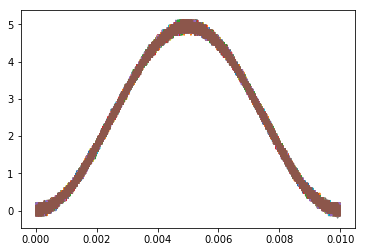

In [69]:
for wave in waves:
    plt.plot(times, wave)

In [14]:
comm_type, comm_order, dat1_offset,dat1_length, dat1_array

(False, False, 346, 1000000, array([ 1, -1,  1, ...,  1,  0,  0], dtype=int8))

In [22]:
%%timeit
osc.visa_handle.write("C3:WF? DESC")
desc = osc._read_ieee_block()
Nsamples, = struct.unpack_from('L', desc, 116)
vert_gain, vert_offset = struct.unpack_from('ff', desc, 156)
horz_dt, horz_offset = struct.unpack_from('fd', desc, 176)

(horz_offset + horz_dt * np.arange(Nsamples),
        vert_offset + vert_gain
        * osc.visa_handle.query_binary_values("C3:WF? DAT1",
                                            datatype='b',
                                            is_big_endian=True,
                                            container=np.array))

233 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


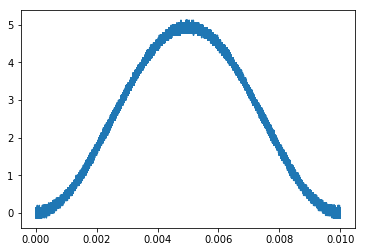

In [23]:
osc.visa_handle.write("C3:WF? DESC")
desc = osc._read_ieee_block()
Nsamples, = struct.unpack_from('L', desc, 116)
vert_gain, vert_offset = struct.unpack_from('ff', desc, 156)
horz_dt, horz_offset = struct.unpack_from('fd', desc, 176)

wave = (horz_offset + horz_dt * np.arange(Nsamples),
        vert_offset + vert_gain
        * osc.visa_handle.query_binary_values("C3:WF? DAT1",
                                            datatype='b',
                                            is_big_endian=True,
                                            container=np.array))

plt.plot(*wave)

In [5]:
osc.close()

In [55]:
import win32com.client
dso=win32com.client.Dispatch("LeCroy.ActiveDSOCtrl.1")

In [56]:
dso.MakeConnection("VXI11: 192.168.1.7")

True

In [57]:
%%timeit
dso.GetScaledWaveformWithTimes("C3", 10000000, 0)

3.69 s ± 99.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


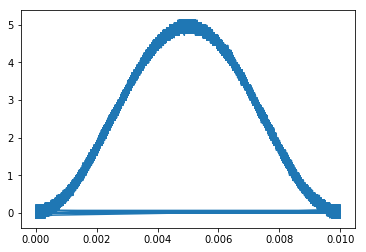

In [58]:
wave_dso = dso.GetScaledWaveformWithTimes("C3", 10000000, 0)
plt.plot(*wave_dso)

In [29]:
np.equal(wave,wave_dso)

array([[False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True]])

In [60]:
dso.Disconnect()

True